In [1]:
# Decide on what kind of models to use as calibration model - maye be not a linear model?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.svm import SVR

In [3]:
# import the datafile
validation_preds_and_true_counts = pd.read_csv("True_tassel_counts/validation_true_and_predicted_counts.csv")

In [4]:
validation_preds_and_true_counts.head()

,name,true_count,Predicted_count
0,Block0204_2020_06_29,0,2.103025
1,Block0204_2020_07_01,0,3.598690
2,Block0204_2020_07_02,0,7.005647
3,Block0204_2020_07_06,0,9.229449
4,Block0204_2020_07_07,2,12.557514


In [5]:
validation_preds_and_true_counts.shape

(32, 3)

In [6]:
# Drop the name?
final_data_df = validation_preds_and_true_counts.drop(["name"], axis = 1)

In [7]:
final_data_df.head()

,true_count,Predicted_count
0,0,2.103025
1,0,3.598690
2,0,7.005647
3,0,9.229449
4,2,12.557514


In [8]:
final_data_df.shape

(32, 2)

In [9]:
# rename the columns
final_data_df.columns = ['y_values', 'x_values']

In [10]:
final_data_df.head()

,y_values,x_values
0,0,2.103025
1,0,3.598690
2,0,7.005647
3,0,9.229449
4,2,12.557514


In [11]:
# split the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(final_data_df['x_values'], final_data_df['y_values'], test_size=0.25, random_state=31)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24,), (24,), (8,), (8,))

In [13]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

In [14]:
test_fold = [-1] * len(X_train) + [0] * len(X_test)
ps = PredefinedSplit(test_fold=test_fold)

# Combine train and test data into one dataset
X_full = np.concatenate([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

In [15]:
y_full.shape

(32,)

In [16]:
# Okay, now I think we ought to fit multiple models that do the predictions really well. Should we maybe go ahead and plo the true vs predicted values for the train data - may be this will give an idea of what models will be the best

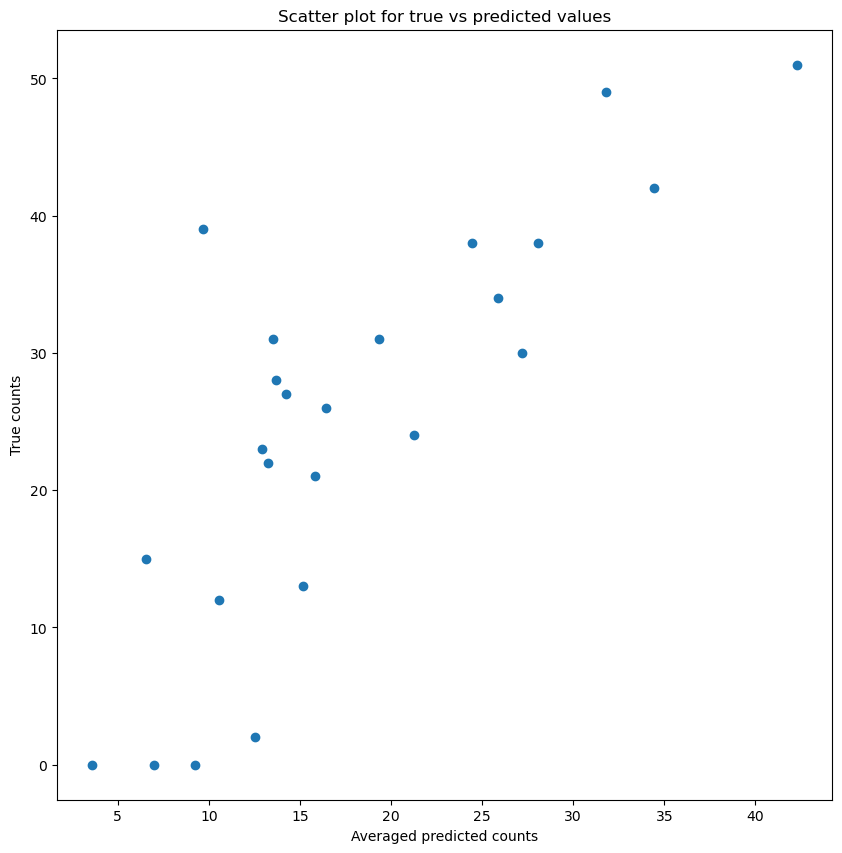

In [17]:
plt.figure(figsize = (10,10))
plt.scatter( X_train, y_train)
plt.title("Scatter plot for true vs predicted values")
plt.xlabel("Averaged predicted counts")
plt.ylabel("True counts")
plt.show()

In [18]:
# well a linear model seems okay - let's start with simple models and also maybe move to a peciptron

In [19]:
# let's try some models with gridsearch

ElasticNet model

In [20]:
# Initialize the ElasticNet model
EN_model = ElasticNet()

In [21]:
# Define the parameter grid
EN_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0],
    'max_iter': [1000, 2000, 5000]
}

In [22]:
# Set up the GridSearchCV
grid_search_EN = GridSearchCV(estimator=EN_model, param_grid=EN_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [23]:
# Fit the grid search to the data
grid_search_EN.fit(X_full, y_full)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 1.0],
                         'max_iter': [1000, 2000, 5000]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search_EN.best_params_}")
print(f"Best score (MSE): {-grid_search_EN.best_score_}")

Best parameters found: {'alpha': 10.0, 'l1_ratio': 0.1, 'max_iter': 1000}
Best score (MSE): 99.99101116117635


In [25]:
# Evaluate the best model on the test set
best_model = grid_search_EN.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test,y_pred)
test_corr = pearsonr(y_test, y_pred)[0]
test_r2 = r2_score(y_test, y_pred)

In [26]:
test_rmse, test_mae, test_corr, test_r2

(9.6354811348306, 8.816986447188398, 0.7074266458546106, 0.4716884690335832)

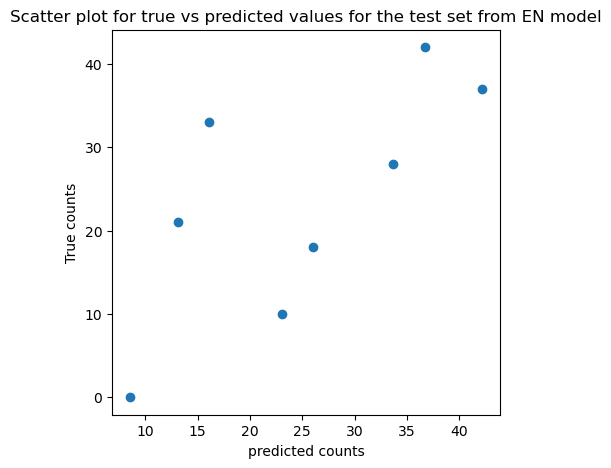

In [27]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter( y_pred, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from EN model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

Linear Regression model

In [28]:
# Initialize the LinearRegression model
LR_model = LinearRegression()

# Define the parameter grid
LR_param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False] # normalize was deprecated, removed in sklearn 1.0
}

In [29]:
# Set up the GridSearchCV
LR_grid_search = GridSearchCV(estimator=LR_model, param_grid=LR_param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=2)


In [30]:
LR_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=False, normalize=True; total time=   0.0s
[CV] END ...............fit_intercept=False, normalize=False; total time=   0.0s


/common/statsgeneral/gayara/tf_with_py38_gpu_29/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/common/statsgeneral/gayara/tf_with_py38_gpu_29/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this es

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=2)

In [31]:
# Print the best parameters and best score
print(f"Best parameters found: {LR_grid_search.best_params_}")
print(f"Best cross-validation score (MSE): {-LR_grid_search.best_score_}")

Best parameters found: {'fit_intercept': True, 'normalize': False}
Best cross-validation score (MSE): 110.2669201779102


In [32]:
# Evaluate the best model on the test set
best_model_LR = LR_grid_search.best_estimator_
y_pred_LR = best_model_LR.predict(X_test)
test_rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR))
test_mae_LR = mean_absolute_error(y_test,y_pred_LR)
test_corr_LR = pearsonr(y_test, y_pred_LR)[0]
test_r2_LR = r2_score(y_test, y_pred_LR)

In [33]:
9.921186994792352*9.921186994792352

98.4299513856369

In [34]:
test_rmse_LR, test_mae_LR, test_corr_LR, test_r2_LR

(9.921186994792352, 9.051303346292261, 0.7074266458546106, 0.43989358151678126)

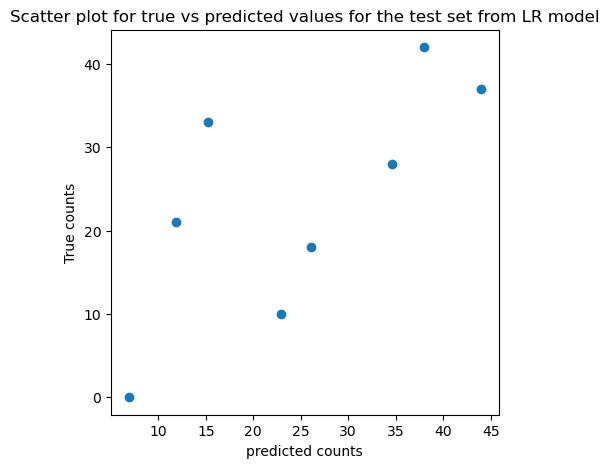

In [35]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_LR, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from LR model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

SVR model

In [36]:
SVR_model = SVR()

In [37]:
SVR_param_grid = {'kernel': ['linear', 'poly'], 'degree': [1,2,3]}

In [38]:
# Set up the GridSearchCV
grid_search_SVR = GridSearchCV(estimator=SVR_model, param_grid=SVR_param_grid, cv=ps, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

In [39]:
# import sklearn

In [40]:
# sklearn.metrics.get_scorer_names()

In [41]:
# Fit the grid search to the data
grid_search_SVR.fit(X_full, y_full)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2, 3], 'kernel': ['linear', 'poly']},
             scoring='neg_mean_absolute_error', verbose=1)

In [42]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search_SVR.best_params_}")
print(f"Best score (MSE): {-grid_search_SVR.best_score_}")

Best parameters found: {'degree': 3, 'kernel': 'poly'}
Best score (MSE): 8.699707664562585


In [43]:
# Evaluate the best model on the test set
best_model_SVR = grid_search_SVR.best_estimator_
y_pred_SVR = best_model_SVR.predict(X_test)
test_rmse_SVR = np.sqrt(mean_squared_error(y_test, y_pred_SVR))
test_mae_SVR = mean_absolute_error(y_test,y_pred_SVR)
test_corr_SVR = pearsonr(y_test, y_pred_SVR)[0]
test_r2_SVR = r2_score(y_test, y_pred_SVR)

In [44]:
test_rmse_SVR, test_mae_SVR, test_corr_SVR, test_r2_SVR

(10.445750217333805, 8.348135284052393, 0.6782819707379752, 0.3790987244076225)

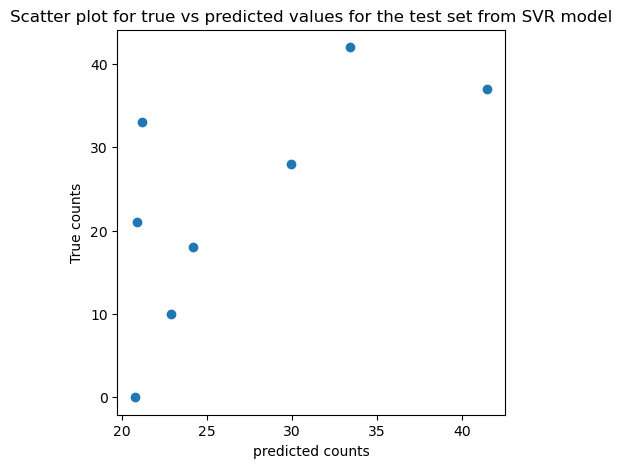

In [45]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_SVR, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from SVR model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()

SGDregressor model

In [46]:
# Initialize the SGDRegressor model
SGD_model = SGDRegressor(random_state=42)

# Define the parameter grid
SGD_param_grid = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1]}

In [47]:
# Set up the GridSearchCV
SGD_grid_search = GridSearchCV(estimator=SGD_model, param_grid=SGD_param_grid, cv=ps, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [48]:
# Fit the grid search to the data
SGD_grid_search.fit(X_full, y_full)

Fitting 1 folds for each of 324 candidates, totalling 324 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0])),
             estimator=SGDRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'eta0': [0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error', verbose=2)

In [49]:
# Print the best parameters and best score
print(f"Best parameters found: {SGD_grid_search.best_params_}")
print(f"Best score (MSE): {-SGD_grid_search.best_score_}")

Best parameters found: {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'l1'}
Best score (MSE): 105.68574054101865


In [50]:
# Evaluate the best model on the test set
best_model_SGD = SGD_grid_search.best_estimator_
y_pred_SGD = best_model_SGD.predict(X_test)
test_rmse_SGD = np.sqrt(mean_squared_error(y_test, y_pred_SGD))
test_mae_SGD = mean_absolute_error(y_test,y_pred_SGD)
test_corr_SGD = pearsonr(y_test, y_pred_SGD)[0]
test_r2_SGD = r2_score(y_test, y_pred_SGD)

In [51]:
test_rmse_SGD, test_mae_SGD, test_corr_SGD, test_r2_SGD

(10.755001111537608,
 9.323550158097689,
 0.7074266458546106,
 0.34179042142907334)

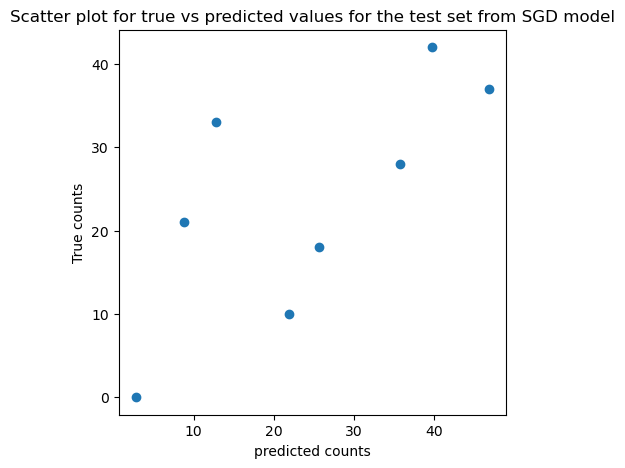

In [52]:
# plot the data test predicted and true values

plt.figure(figsize = (5,5))
plt.scatter(y_pred_SGD, y_test)
plt.title("Scatter plot for true vs predicted values for the test set from SGD model")
plt.xlabel("predicted counts")
plt.ylabel("True counts")
plt.show()